### Required Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity
from scipy.integrate import cumulative_trapezoid
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import DBSCAN
import seaborn as sns
import itertools



/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_27110/1994687294.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
models_dir = '/Applications/UNI/Thesis/new_data'
os.makedirs(models_dir, exist_ok=True) 


### Data

European Social Survey European Research Infrastructure (ESS ERIC). (2023). ESS8 - integrated file, edition 2.3 [Data set]. Sikt - Norwegian Agency for Shared Services in Education and Research. https://doi.org/10.21338/ess8e02_3

Data collection period: 01-09-2016 - 31-01-2017




In [3]:

# Load your data
df = pd.read_csv('/Applications/UNI/Thesis/datasets/ESS8e02_3.csv')

# Filter the DataFrame for rows where 'cntry' is 'NL'
netherlands_df = df[df['cntry'] == 'NL']


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_27110/1230602784.py:2: DtypeWarning: Columns (168) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Applications/UNI/Thesis/datasets/ESS8e02_3.csv')


In [4]:
netherlands_df

,name,essround,edition,proddate,idno,cntry,dweight,pspwght,pweight,anweight,...,inwmms,inwyys,inwshh,inwsmm,inwdde,inwmme,inwyye,inwehh,inwemm,inwtm
32909,ESS8e02_3,8,2.3,23.11.2023,11310081,NL,1.012680,1.047340,0.843507,0.883439,...,1,2017,17,0,27,1,2017,18,32,92.0
32910,ESS8e02_3,8,2.3,23.11.2023,11310110,NL,0.506340,0.586621,0.843507,0.494819,...,11,2016,13,56,17,11,2016,14,58,62.0
32911,ESS8e02_3,8,2.3,23.11.2023,11310165,NL,0.506340,0.434278,0.843507,0.366316,...,10,2016,10,0,11,10,2016,19,15,555.0
32912,ESS8e02_3,8,2.3,23.11.2023,11310169,NL,2.025359,2.346485,0.843507,1.979276,...,11,2016,13,36,25,11,2016,14,49,73.0
32913,ESS8e02_3,8,2.3,23.11.2023,11310171,NL,0.506340,0.739326,0.843507,0.623627,...,11,2016,13,12,22,11,2016,14,33,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34585,ESS8e02_3,8,2.3,23.11.2023,61430929,NL,0.506340,0.564168,0.843507,0.475879,...,11,2016,10,49,14,11,2016,12,11,82.0
34586,ESS8e02_3,8,2.3,23.11.2023,61431750,NL,1.012680,1.033918,0.843507,0.872116,...,11,2016,19,38,16,11,2016,20,55,77.0
34587,ESS8e02_3,8,2.3,23.11.2023,61432247,NL,1.012680,1.033918,0.843507,0.872116,...,11,2016,13,43,15,11,2016,14,43,60.0
34588,ESS8e02_3,8,2.3,23.11.2023,61432846,NL,1.012680,1.158207,0.843507,0.976955,...,1,2017,9,30,19,1,2017,10,49,79.0


### Function to process KDE, save fitted model and plot

In [5]:
def process_kde(column, valid_range, models_dir, reverse_scale=False, max_value=None):
    # Filter and process the data for the column
    valid_df = netherlands_df[netherlands_df[column].isin(valid_range)].copy()
    valid_df[column] = valid_df[column].astype(float)

    if reverse_scale:
        # Reverse the scale
        valid_df[column] = (max_value + 1) - valid_df[column]

    # Normalize to 0-1 scale
    valid_df[column] = valid_df[column] / max_value

    # Ensure data is within [0, 1] before fitting KDE
    valid_df[column] = np.clip(valid_df[column], 0, 1)

    # Setup the grid search with Leave-One-Out cross-validation
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=LeaveOneOut())
    grid.fit(valid_df[column].values.reshape(-1, 1))

    # Find the optimal bandwidth
    best_bandwidth = grid.best_params_['bandwidth']
    print(f"Best bandwidth for {column}: ", best_bandwidth)

    # Fit and plot KDE with the best bandwidth
    kde = KernelDensity(kernel='gaussian', bandwidth=best_bandwidth)
    kde.fit(valid_df[column].values.reshape(-1, 1))

    model_path = os.path.join(models_dir, f'kde_{column}.pkl')
    
    # Save the fitted model
    joblib.dump(kde, model_path)

    # Create an array of values for plotting the KDE
    x_d = np.linspace(0, 1, 1000).reshape(-1, 1)
    logprob = kde.score_samples(x_d)

    pdf = np.exp(logprob)
    cdf = cumulative_trapezoid(pdf, x_d[:, 0], initial=0)

    # Plot the KDE
    plt.fill_between(x_d[:, 0], np.exp(logprob),color='green', alpha=0.5)
    plt.plot(valid_df[column].values, np.full_like(valid_df[column].values, -0.01), '|k', markeredgewidth=1)
    plt.title(f'KDE of {column}')
    plt.show()

    # Plot the CDF
    plt.plot(x_d[:, 0], cdf, label='CDF')
    plt.title(f'CDF of {column}')
    plt.xlabel('Value')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.show()

    # Save the CDF and corresponding x values
    cdf_path = os.path.join(models_dir, f'cdf_{column}.pkl')
    joblib.dump((x_d[:, 0], cdf), cdf_path)

    return x_d[:, 0], pdf




### ccrdprs - To what extent feel personal responsibility to reduce climate change

Best bandwidth for ccrdprs:  0.1


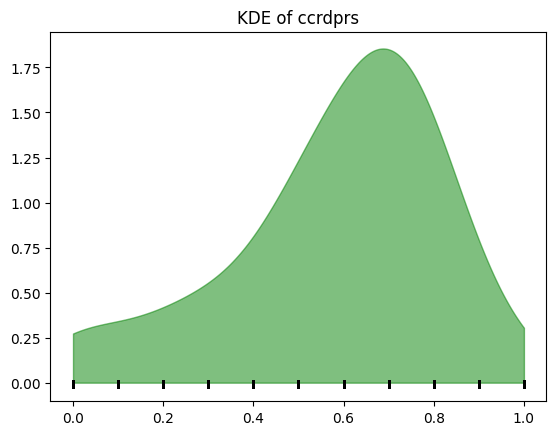

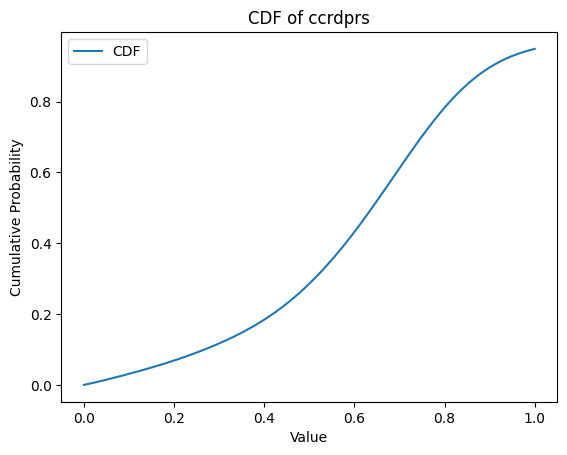

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [6]:
process_kde('ccrdprs', range(11), models_dir, False, 10)

### lkredcc - Imagine large numbers of people limit energy use, how likely reduce climate change.

Best bandwidth for lkredcc:  0.1


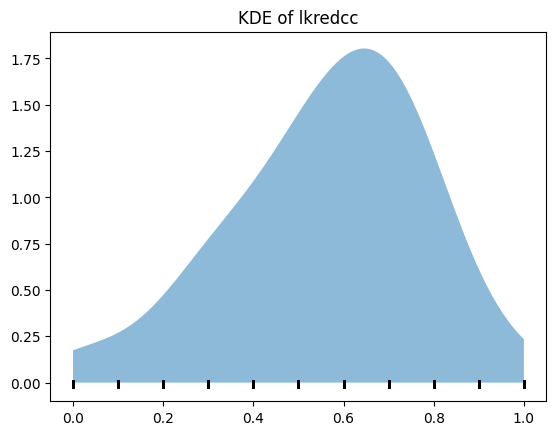

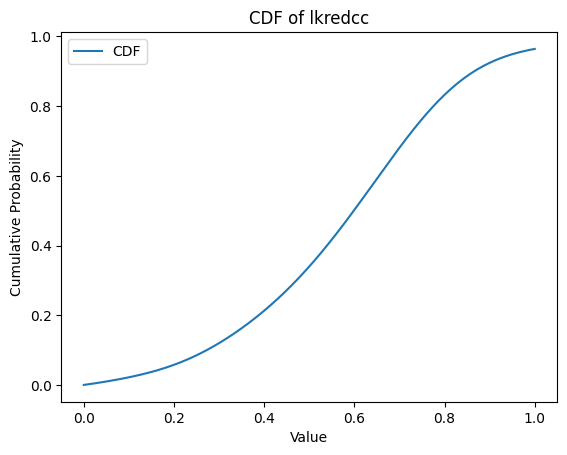

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [22]:
process_kde('lkredcc', range(11), models_dir, False, 10)

### wrclmch - How worried about climate change

Best bandwidth for wrclmch:  0.1


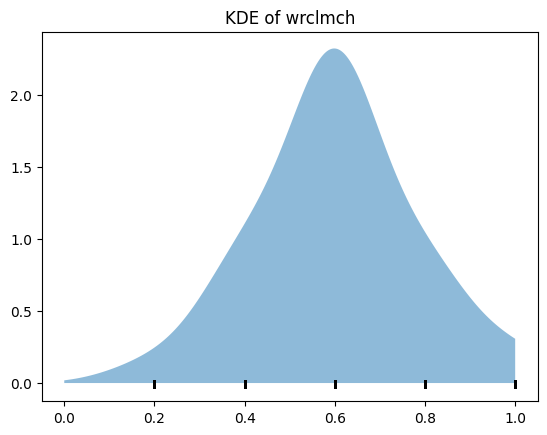

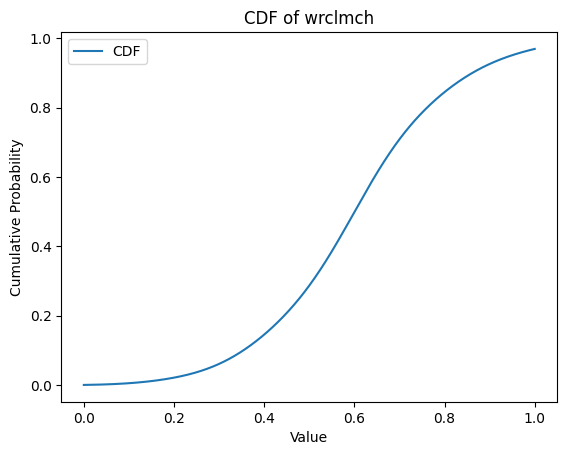

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [23]:
process_kde('wrclmch', range(6), models_dir, False, 5)


### gvsrdcc - How likely, governments in enough countries take action to reduce climate change

Best bandwidth for gvsrdcc:  0.1


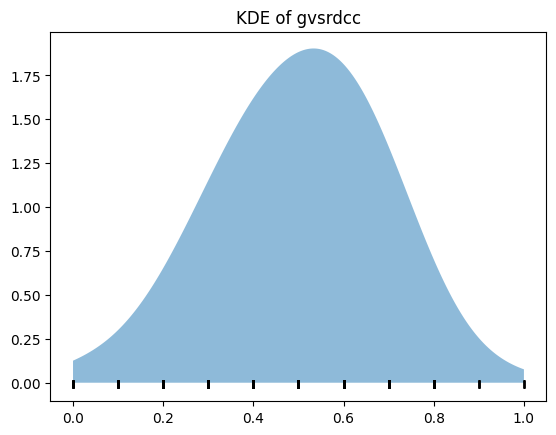

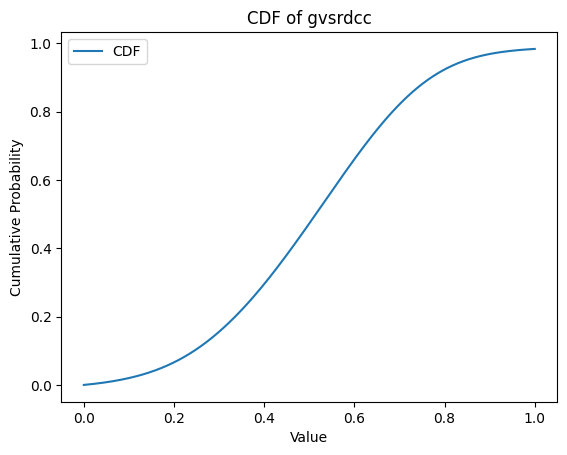

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [24]:
process_kde('gvsrdcc', range(11), models_dir, False, 10)


### inctxff - Favour increase taxes on fossil fuels to reduce climate change

Best bandwidth for inctxff:  0.1


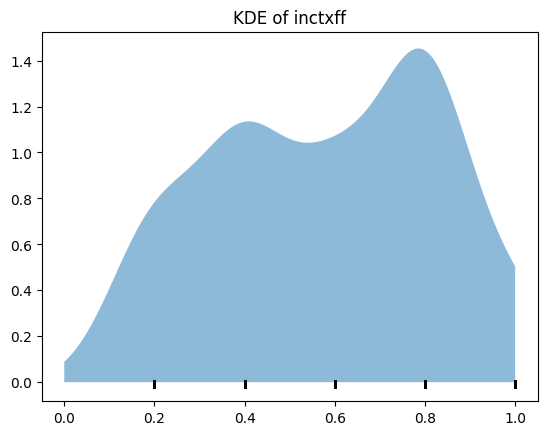

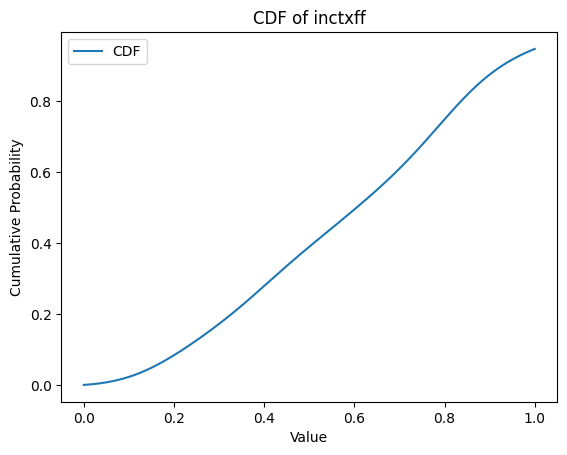

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [25]:
process_kde('inctxff', range(6), models_dir, True, 5)


### sbsrnen - Favour subsidise renewable energy to reduce climate change


Best bandwidth for sbsrnen:  0.1


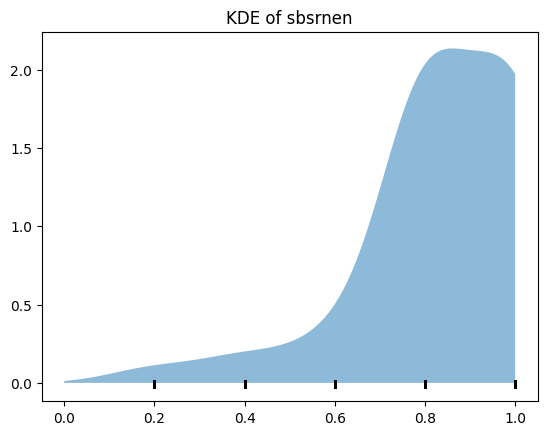

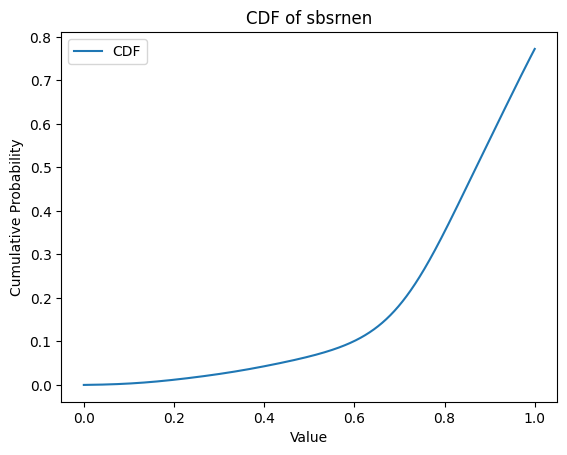

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [26]:
process_kde('sbsrnen', range(6), models_dir, True, 5)


### iplylfr - Important to be loyal to friends and devote to people close



Best bandwidth for iplylfr:  0.1


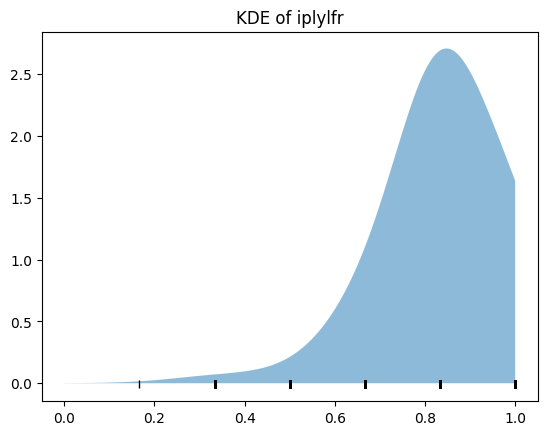

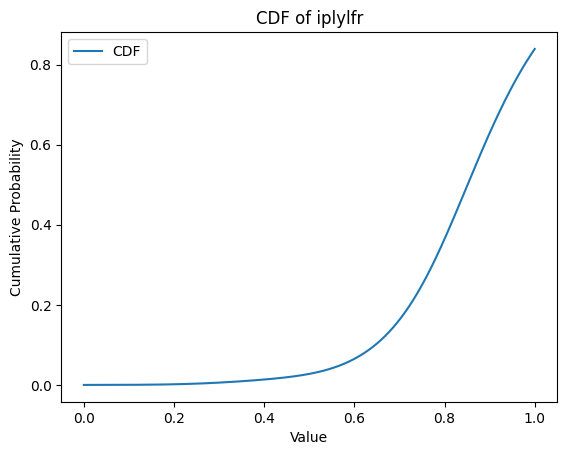

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [27]:
process_kde('iplylfr', range(7), models_dir, True, 6)


### Social Meet

Best bandwidth for sclmeet:  0.1


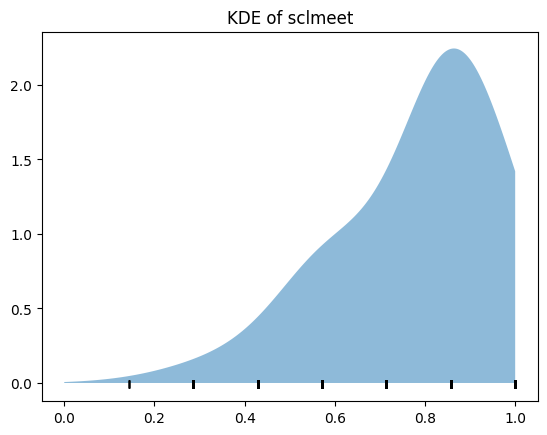

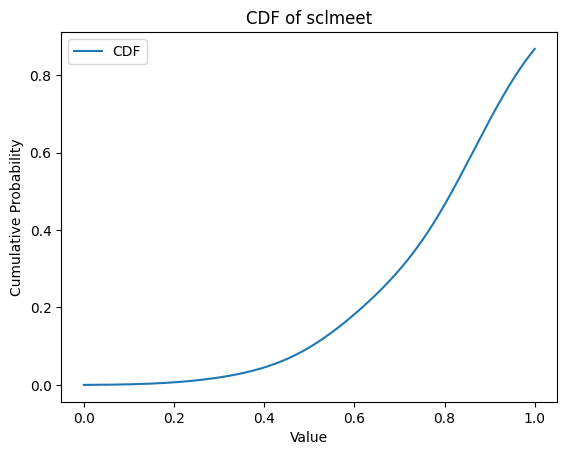

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [28]:
process_kde('sclmeet', range(8), models_dir, False, 7)


### Discuss intimate and personal matters?

Best bandwidth for inprdsc:  0.1


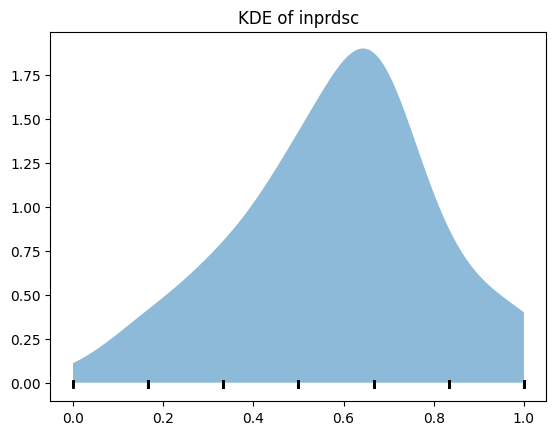

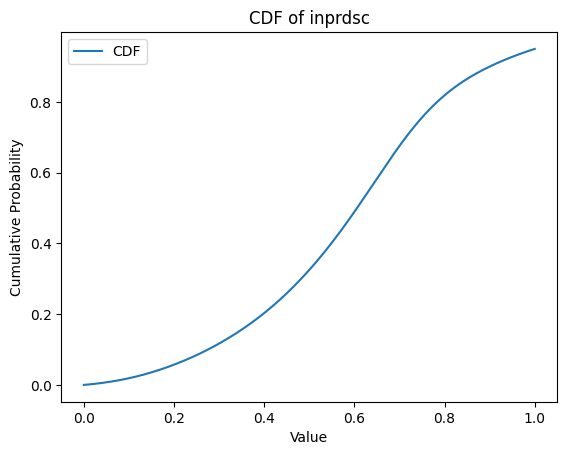

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [29]:
process_kde('inprdsc', range(7), models_dir, False, 6)


### wrkctra -  Employment contract unlimited or limited duration

Best bandwidth for wrkctra:  0.1


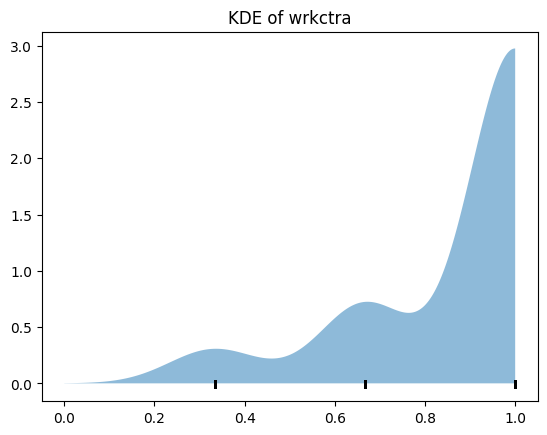

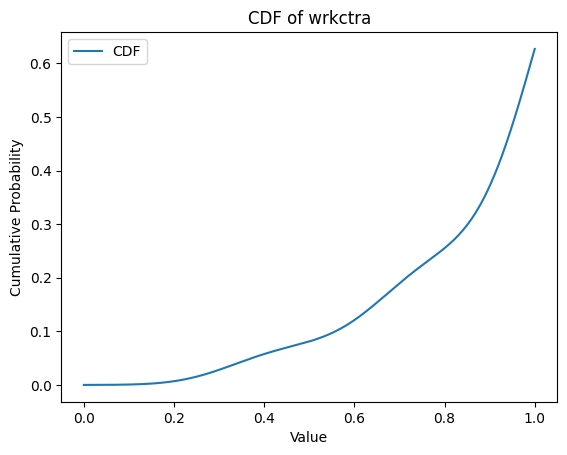

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [30]:
process_kde('wrkctra', range(4), models_dir, True, 3)


### hincfel - Feeling household income

1	Living comfortably on present income

2	Coping on present income

3	Difficult on present income

4	Very difficult on present income

Best bandwidth for hincfel:  0.1


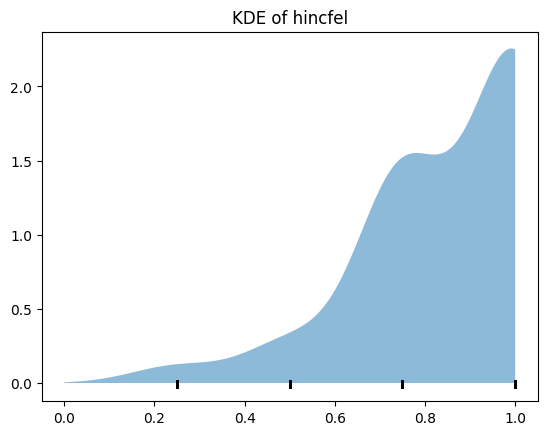

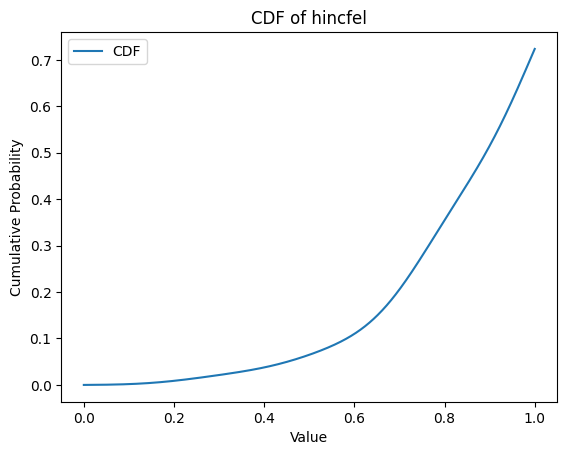

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [31]:
process_kde('hincfel', range(5), models_dir, True, 4)


### imprich - Important to be rich, have money and expensive things

Best bandwidth for imprich:  0.1


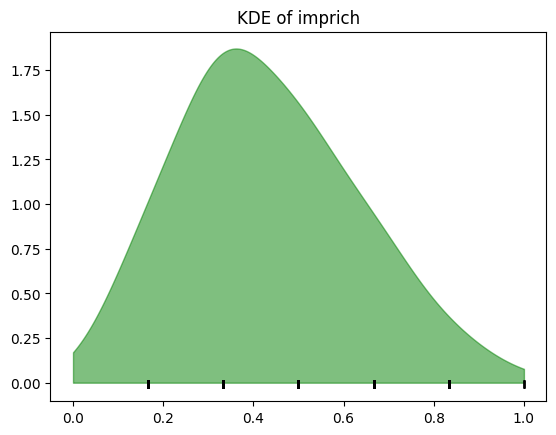

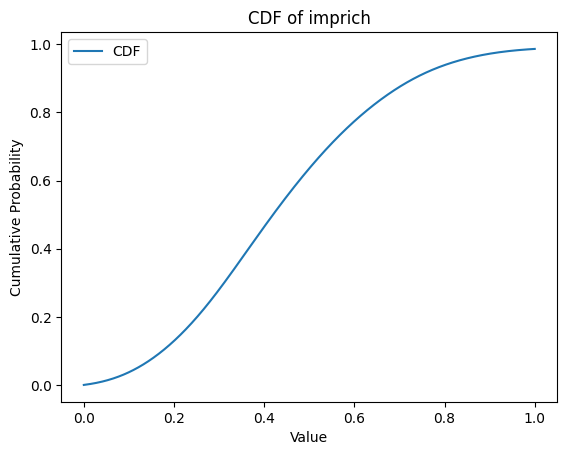

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [7]:
process_kde('imprich', range(7), models_dir, True, 6)


### impenv - Important to care for nature and environment

Best bandwidth for impenv:  0.1


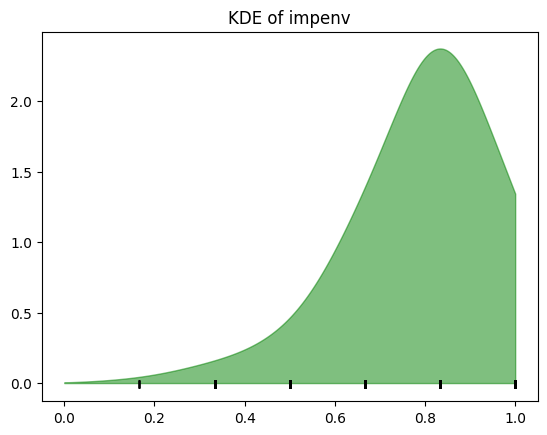

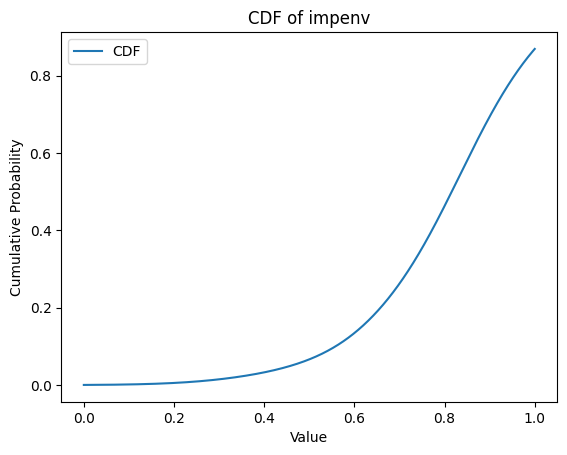

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [8]:
process_kde('impenv', range(7), models_dir, True, 6)


### impfree - Important to make own decisions and be free

Best bandwidth for impfree:  0.1


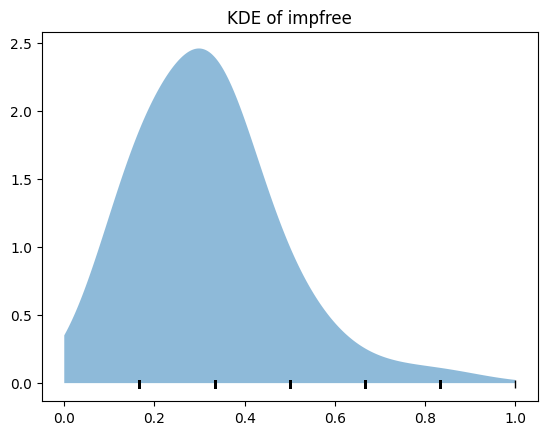

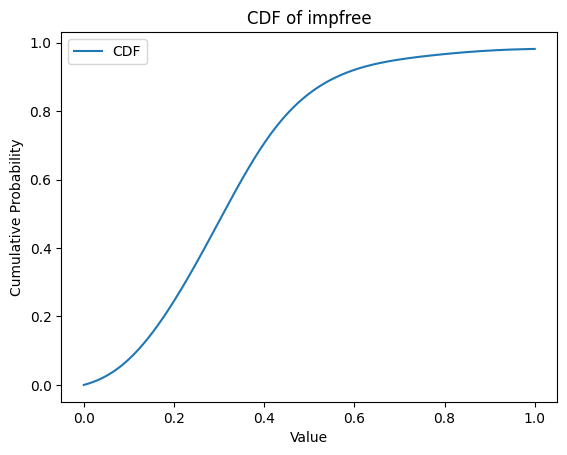

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [34]:
process_kde('impfree', range(7), models_dir, False, 6)


### ipfrule - Important to do what is told and follow rules

Best bandwidth for ipfrule:  0.1


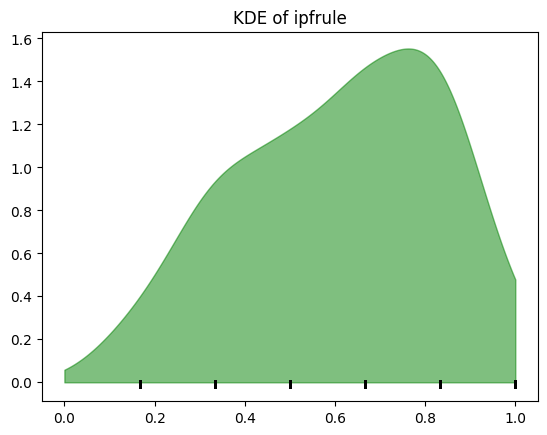

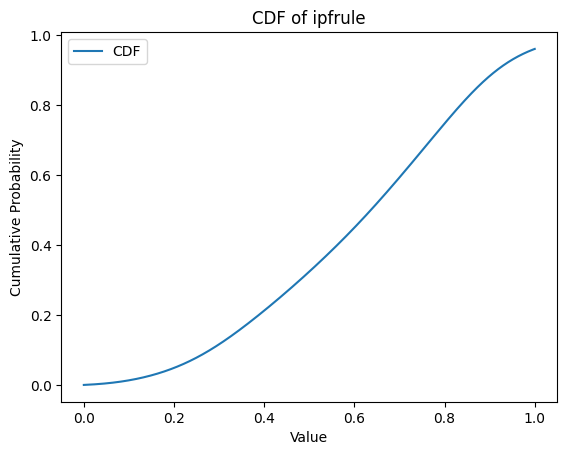

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [9]:
process_kde('ipfrule', range(7), models_dir, True, 6)

### eneffap - How likely to buy most energy efficient home appliance

Best bandwidth for eneffap:  0.1


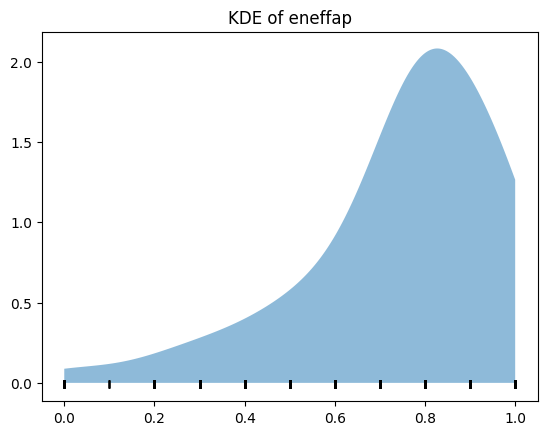

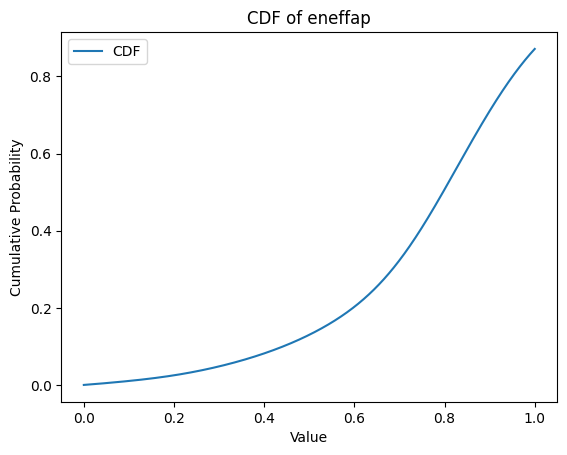

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [36]:
process_kde('eneffap', range(11), models_dir, False, 10)

### wrenexp - How worried, energy too expensive for many people

Best bandwidth for wrenexp:  0.1


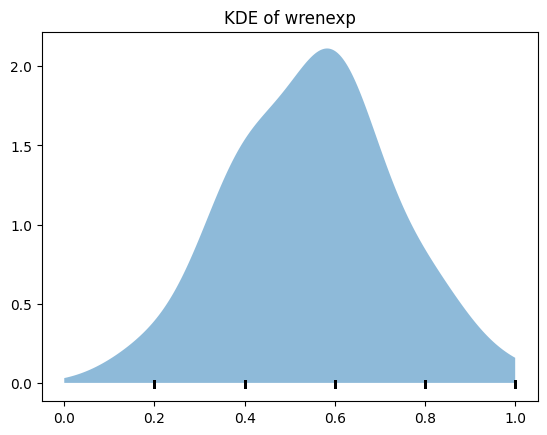

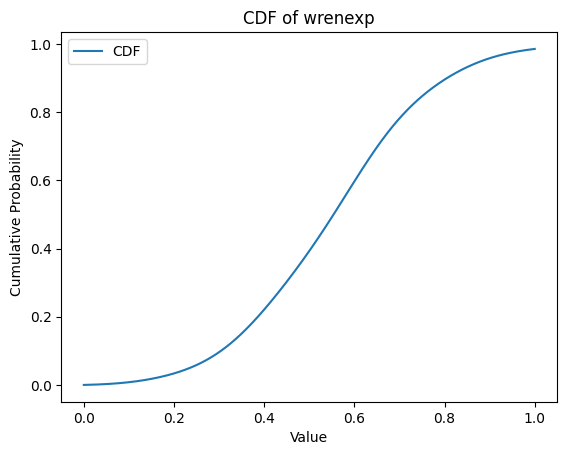

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [37]:
process_kde('wrenexp', range(6), models_dir, False, 5)

Best bandwidth for mnactic:  0.1


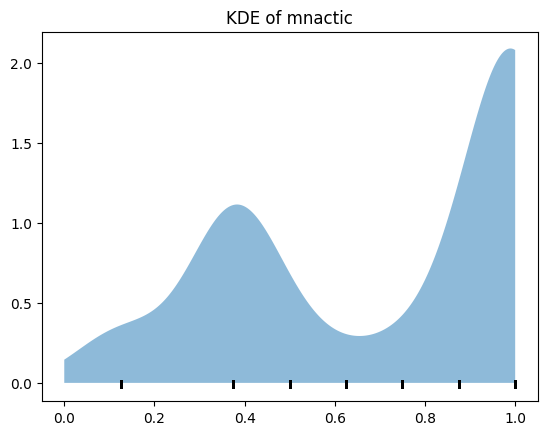

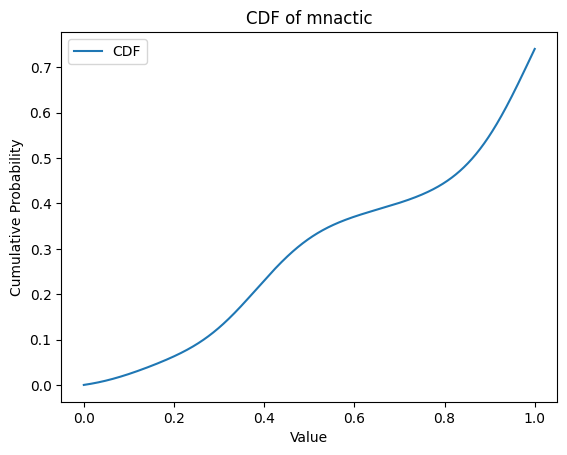

(array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
        0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
        0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
        0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
        0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
        0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
        0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
        0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
        0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
        0.04504505, 0.04604605, 0.04704705, 0.04804805, 0.04904905,
        0.05005005, 0.05105105, 0.05205205, 0.05305305, 0.05405405,
        0.05505506, 0.05605606, 0.05705706, 0.05805806, 0.05905906,
        0.06006006, 0.06106106, 0.06206206, 0.06306306, 0.06406406,
        0.06506507, 0.06606607, 0.06706707, 0.06806807, 0.06906907,
        0.07007007, 0.07107107, 0.07207207, 0.07

In [38]:
process_kde('mnactic', range(9), models_dir, True, 8)

# **How to use all of this data?**

## All Climate Change Data

'eneffap', 'rdcenr', 'cflsenr', 'elgcoal', 'elgngas', 'elghydr', 'elgnuc', 'elgsun', 
                     'elgwind', 'elgbio', 'wrpwrct', 'wrenexp', 'wrdpimp', 'wrdpfos', 'wrntdis', 
                     'wrinspw', 'wrtcfl', 'wrtratc', 'clmchng', 'clmthgt1', 'clmthgt2', 'ccnthum', 
                     'ccrdprs', 'wrclmch', 'ccgdbd', 'lkredcc', 'lklmten', 'gvsrdcc', 'ownrdcc', 
                     'inctxff', 'sbsrnen', 'banhhap'

Correlation Matrix:
           rdcenr   ccrdprs   wrclmch   ownrdcc    impenv
rdcenr   1.000000 -0.015062  0.004416 -0.044655 -0.046701
ccrdprs -0.015062  1.000000  0.346378  0.528404 -0.061140
wrclmch  0.004416  0.346378  1.000000  0.257198 -0.261786
ownrdcc -0.044655  0.528404  0.257198  1.000000  0.003236
impenv  -0.046701 -0.061140 -0.261786  0.003236  1.000000


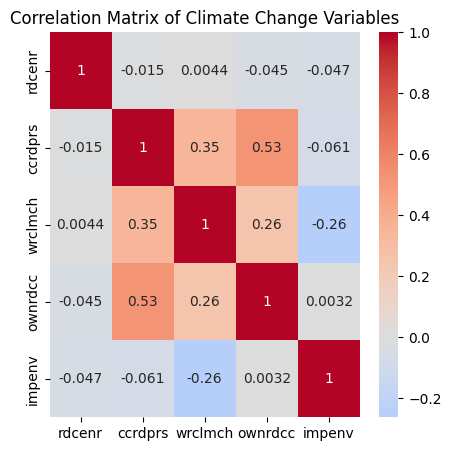

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the relevant variables
climate_change_vars = ['rdcenr', 'ccrdprs', 'wrclmch', 'ownrdcc', 'impenv']

# Filter the DataFrame for the selected columns
climate_change_data = netherlands_df[climate_change_vars].copy()
climate_change_data.dropna(inplace=True)

# Compute the correlation matrix
correlation_matrix = climate_change_data.corr()

print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Climate Change Variables')
plt.show()



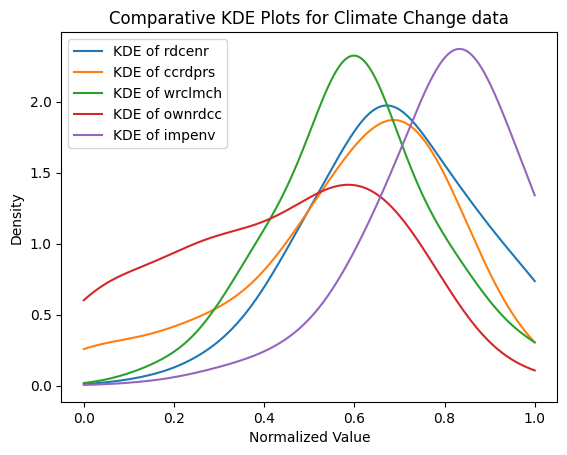

         rdcenr  ccrdprs  wrclmch  ownrdcc    impenv
32909  0.833333      0.8      0.8      0.3  0.833333
32910  0.500000      0.5      0.6      0.6  0.833333
32911  0.666667      0.7      0.6      0.7  0.833333
32912  0.833333      0.5      0.6      0.8  0.666667
32913  1.000000      0.7      0.6      0.0  0.833333
...         ...      ...      ...      ...       ...
34585  0.666667      0.5      0.8      0.5  0.833333
34586  0.500000      0.7      0.6      0.6  0.833333
34587  0.500000      0.2      0.6      0.2  0.500000
34588  0.666667      0.6      0.6      0.6  0.666667
34589  1.000000      0.2      0.6      0.2  0.833333

[1625 rows x 5 columns]
Cronbach's Alpha: 0.6250109083900912


In [78]:
climate_change_vars2 = [ 'rdcenr','ccrdprs', 'wrclmch','ownrdcc', 'impenv']

# Creating a specific DataFrame for Climate Change
climate_change_data = netherlands_df[climate_change_vars2].copy()


non_believer_responses = {
    'ccrdprs': 0,
    'wrclmch': 1,
    'ccgdbd': 5,  
    'lkredcc': 0,
    'ownrdcc': 0
}

valid_range_dict = {
    'rdcenr': range(1, 7),
    'ccrdprs': range(0, 11),
    'wrclmch': range(1, 6),
    'ccgdbd': range(0, 11),
    'lkredcc': range(0, 11),
    'ownrdcc': range(0, 11),
    'impenv': range(1,7),
}


reverse_scale_dict = {
     'rdcenr': False, 
     'ccrdprs': False, 
     'wrclmch': False,
    'ccgdbd': False, 
    'lkredcc': False, 
     'ownrdcc': False, 
    'impenv': True
}


max_value_dict = {
     'rdcenr': 6, 
     'ccrdprs': 10, 
     'wrclmch': 5,
    'ccgdbd': 10, 
    'lkredcc': 10, 
 'ownrdcc': 10, 
     'impenv': 6
}


def preprocess_data(df, column, reverse_scale, max_value):
    if reverse_scale:
        df[column] = (max_value + 1) - df[column]
    df[column] /= max_value

# Define directories and ensure they exist
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Function to plot KDE and save model
def simplified_kde_plot(column, df):
    # Make sure the data is a float and drop any NaNs that could disrupt KDE
    valid_df = df[[column]].dropna().astype(float)

    # Fit KDE and save the model
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1)
    kde.fit(valid_df.values.reshape(-1, 1))
    model_path = os.path.join(models_dir, f'kde_{column}.pkl')
    joblib.dump(kde, model_path)

    # Plotting KDE
    x_d = np.linspace(0, 1, 1000).reshape(-1, 1)
    logprob = kde.score_samples(x_d)
    pdf = np.exp(logprob)
    plt.plot(x_d, pdf, label=f'KDE of {column}')

# Function to calculate Cronbach's Alpha
def cronbach_alpha(df):
    item_variances = df.var(axis=0, ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    n_items = len(df.columns)
    return (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_variance)


# Preprocessing data
for column in climate_change_vars2:
    original_count = climate_change_data.shape[0]
    climate_change_data = climate_change_data[climate_change_data[column].isin(valid_range_dict[column])]
    filtered_count = climate_change_data.shape[0]
   #print(f"{column}: Reduced from {original_count} to {filtered_count}")
    preprocess_data(climate_change_data, column, reverse_scale_dict[column], max_value_dict[column])


# Plotting KDE for each variable
for column in climate_change_vars2:
    simplified_kde_plot(column, climate_change_data)

plt.title('Comparative KDE Plots for Climate Change data')
plt.xlabel('Normalized Value')
plt.ylabel('Density')
plt.legend()
plt.show()

print(climate_change_data)
# Calculate and print Cronbach's Alpha
alpha = cronbach_alpha(climate_change_data)  # Ensure no NaNs before calculating
print(f"Cronbach's Alpha: {alpha}")

### PCA

Explained Variance Ratio: [0.36063228 0.22536684 0.19427793 0.12767258 0.09205038]
Cumulative Explained Variance: [0.36063228 0.58599911 0.78027705 0.90794962 1.        ]


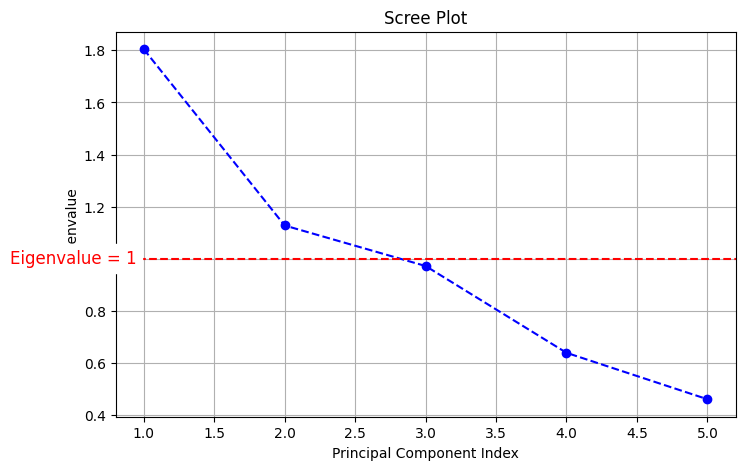

In [67]:



# Define the relevant variables
climate_change_vars = ['rdcenr', 'ccrdprs', 'wrclmch', 'ownrdcc', 'impenv']

# Filter the DataFrame for the selected columns and preprocess
climate_change_data = netherlands_df[climate_change_vars].copy()
climate_change_data.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(climate_change_data)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
eigenvalues = pca.explained_variance_

print("Explained Variance Ratio:", explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)

# Plot the scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--', color='b')
plt.xlabel('Principal Component Index')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid(True)
plt.axhline(y=1, color='r', linestyle='--')
plt.text(0.5, 1, 'Eigenvalue = 1', color = 'red', fontsize=12, va='center', ha='center', backgroundcolor='w')
plt.show()


Explained variance ratio: [0.36063228 0.22536684]
Total explained variance: 0.5859991127603206


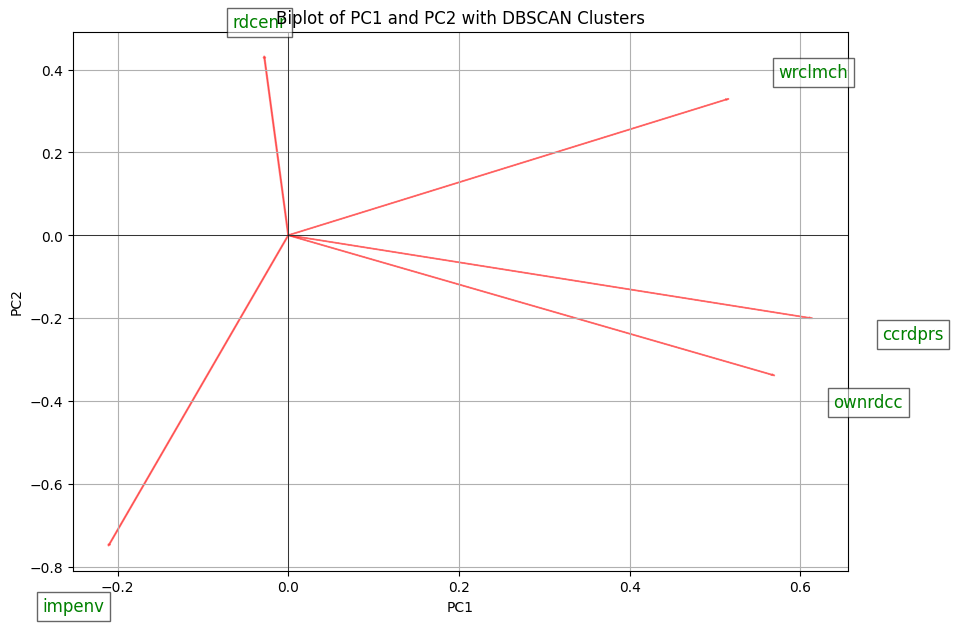

Clusters based on DBSCAN:
              PC1       PC2  Cluster
rdcenr  -0.027913  0.428230        0
ccrdprs  0.609988 -0.199394        1
wrclmch  0.512527  0.327404        2
ownrdcc  0.566149 -0.336581        1
impenv  -0.209586 -0.745910        3
Cronbach's Alpha for Cluster 0: Not enough variables to calculate alpha
Cronbach's Alpha for Cluster 1: 0.6856551385442282 with variables ['ccrdprs', 'ownrdcc']
Cronbach's Alpha for Cluster 2: Not enough variables to calculate alpha
Cronbach's Alpha for Cluster 3: Not enough variables to calculate alpha
Cluster Alphas: {1: 0.6856551385442282}


In [53]:

# Define the relevant variables
climate_change_vars3 = [ 'rdcenr','ccrdprs', 'wrclmch', 'ownrdcc', 'impenv']

# Ensure you have the climate_change_data with appropriate preprocessing
# Creating a specific DataFrame for Climate Change
climate_change_data = netherlands_df[climate_change_vars3].copy()

# Preprocess the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(climate_change_data)

# Perform PCA
pca = PCA(n_components=2)  # You can adjust the number of components based on your needs
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame to display principal components more clearly
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(2)])

# Loadings of the variables on each principal component
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(2)], index=climate_change_data.columns)

# Print explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", sum(pca.explained_variance_ratio_))

# Apply DBSCAN clustering on loadings
dbscan = DBSCAN(eps=0.3, min_samples=1)
cluster_labels = dbscan.fit_predict(loadings)

# Plot the biplot with DBSCAN clusters
plt.figure(figsize=(10, 7))
origin = [0, 0]  # origin point

# Plot loadings with cluster labels
for i, (comp1, comp2) in enumerate(loadings.values):
    plt.arrow(origin[0], origin[1], comp1, comp2, color='r', alpha=0.5)
    plt.text(comp1*1.2, comp2*1.2, climate_change_data.columns[i], 
             color='g', ha='center', va='center', fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='black'))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of PC1 and PC2 with DBSCAN Clusters')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

# Create a DataFrame for cluster labels
loadings['Cluster'] = cluster_labels
print("Clusters based on DBSCAN:")
print(loadings)

# Calculate Cronbach's Alpha for each cluster
def cronbach_alpha(df):
    item_variances = df.var(axis=0, ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    n_items = len(df.columns)
    return (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_variance)

cluster_alphas = {}
for cluster in np.unique(cluster_labels):
    cluster_vars = loadings[loadings['Cluster'] == cluster].index.tolist()
    if len(cluster_vars) > 1:
        alpha = cronbach_alpha(climate_change_data[cluster_vars].dropna())
        cluster_alphas[cluster] = alpha
        print(f"Cronbach's Alpha for Cluster {cluster}: {alpha} with variables {cluster_vars}")
    else:
        print(f"Cronbach's Alpha for Cluster {cluster}: Not enough variables to calculate alpha")

print("Cluster Alphas:", cluster_alphas)


wrmclmch - how worried about climate change

lklmten- how likely large numbers of people limit energy use

ownrdcc - how likely limiting own energy use reduce climate change

impenv - important to care for nature and environment


In [68]:

# Define the relevant variables
climate_change_vars = ['rdcenr', 'ccrdprs', 'wrclmch', 'ownrdcc', 'impenv']

# Filter the DataFrame for the selected columns and preprocess
climate_change_data = netherlands_df[climate_change_vars].copy()
climate_change_data.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(climate_change_data)

# Perform PCA with two principal components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal component scores
pc_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(2)])

print(pc_df.head())

# Get the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for the loadings
loading_df = pd.DataFrame(loadings, index=climate_change_vars, columns=[f'PC{i+1}' for i in range(2)])

print("Loadings:")
print(loading_df)

# Identify the variables with the highest absolute loadings for each principal component
highest_loadings = loading_df.apply(lambda x: x.abs().nlargest(1).index[0])

print("Variables with highest absolute loadings for each principal component:")
print(highest_loadings)


        PC1       PC2
0  0.474310  0.668290
1 -0.101475  0.016751
2  0.074161  0.077783
3 -0.215603 -0.490092
4 -0.309252  0.565861
Loadings:
              PC1       PC2
rdcenr  -0.037493  0.454712
ccrdprs  0.819347 -0.211725
wrclmch  0.688436  0.347651
ownrdcc  0.760462 -0.357395
impenv  -0.281520 -0.792037
Variables with highest absolute loadings for each principal component:
PC1    ccrdprs
PC2     impenv
dtype: object


Preference Variables:

These reflect an individual's attitudes, values, or inclinations towards sustainability and environmental issues.

wrmclmch - How worried about climate change
Reason: This variable captures an individual's concern about climate change, which reflects their personal values and attitudes towards the environment.

impenv - Important to care for nature and environment
Reason: This variable directly measures the importance an individual places on caring for the environment, which is a reflection of their personal values and preferences.

Weight Variables:

These reflect the practical influence or importance placed on these preferences when making decisions, especially considering factors such as societal influence.

lklmten - How likely large numbers of people limit energy use
Reason: This variable captures an individual's perception of societal action towards energy use reduction, indicating how much they consider societal behavior in their decision-making process.

ownrdcc - How likely limiting own energy use reduce climate change
Reason: This variable reflects an individual's belief in the impact of their own actions on climate change, indicating how much they weigh their environmental preferences in their personal actions.

## All Social Data

Links to conformity, how much your social network impacts you

'ppltrst', 'pplfair', 'pplhlp','sclmeet','inprdsc', 'sclact', 'ipbhprp','ipfrule','iplylfr'

ppltrst - Most people can be trusted or you can't be too careful.
This variable measures general trust in people, which can reflect the degree to which someone conforms to a generally trusting or mistrustful societal norm. ALL

pplfair - Most people try to take advantage of you, or try to be fair.
Reflects perceptions of fairness in others, which can influence and be influenced by social norms and interactions.ALL

pplhlp - Most of the time people are helpful or mostly looking out for themselves.
Indicates perceptions of altruism or self-interest in others, potentially shaped by the social environment. ALL

sclmeet - How often socially meet with friends, relatives or colleagues.
Directly related to social interaction frequency, reflecting how integrated a person is within their social network. ALL

inprdsc - How many people with whom you can discuss intimate and personal matters.
Measures the closeness and extent of an individual's social support network, indicative of social integration and potential conformity to social norms. ALL

sclact - Take part in social activities compared to others of the same age.
Assesses engagement in social activities, which can be influenced by peer behavior and societal expectations. ALL

ipbhprp - Important to behave properly.
Reflects the importance placed on adhering to socially accepted norms and behaviors. ALL

ipfrule - Important to do what is told and follow rules.
Highlights the value placed on obedience and conformity to established rules, which is often a reflection of societal influence. ALL

iplylfr - Important to be loyal to friends and devote to people close.
Indicates the value placed on loyalty within one's social network, which can be a form of social conformity.ALL

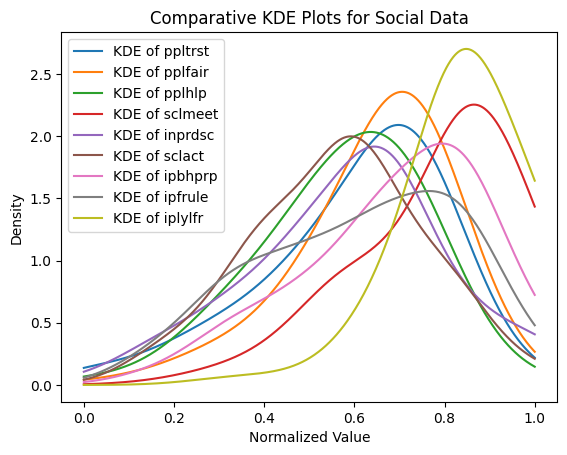

Cronbach's Alpha: 0.4936930129954461


In [70]:
# Define the variables for each category
social_vars = ['ppltrst','pplfair','pplhlp','sclmeet', 'inprdsc','sclact','ipbhprp','ipfrule','iplylfr']

# Creating a specific DataFrame for Climate Change
social_data = netherlands_df[social_vars].copy()


valid_range_dict = {
    'ppltrst': range(0, 11),
    'pplfair': range(0, 11),
    'pplhlp': range(0, 11),
    'sclmeet': range(1, 8),
    'inprdsc': range(0, 7),
    'sclact': range(1, 6),
    'ipbhprp': range(1, 7),
    'ipfrule': range(1, 7),
    'iplylfr': range(1, 7)
}

reverse_scale_dict = {
    'ppltrst': False,  # Higher values indicate more trust, no need to reverse.
    'pplfair': False,  # Higher values indicate seeing people as fairer, no need to reverse.
    'pplhlp': False,   # Higher values indicate seeing people as more helpful, no need to reverse.
    'sclmeet': False,  # Higher values already indicate more frequent social meetings.
    'inprdsc': False,  # Higher values indicate more intimate connections.
    'sclact': False,   # Higher values already mean more social activity.
    'ipbhprp': True,   # Lower values indicate it is more like them; reverse to align.
    'ipfrule': True,   # Lower values indicate more rule-following; reverse to align.
    'iplylfr': True    # Lower values indicate more loyalty; reverse to align.
}

max_value_dict = {
    'ppltrst': 10,
    'pplfair': 10,
    'pplhlp': 10,
    'sclmeet': 7,
    'inprdsc': 6, 
    'sclact': 5,
    'ipbhprp': 6,
    'ipfrule': 6,
    'iplylfr': 6
}

# Preprocessing data
for column in social_vars:
    original_count = social_data.shape[0]
    social_data = social_data[social_data[column].isin(valid_range_dict[column])]
    filtered_count = social_data.shape[0]
    #print(f"{column}: Reduced from {original_count} to {filtered_count}")
    preprocess_data(social_data, column, reverse_scale_dict[column], max_value_dict[column])


# Plotting KDE for each variable
for column in social_vars:
    simplified_kde_plot(column, social_data)

plt.title('Comparative KDE Plots for Social Data')
plt.xlabel('Normalized Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Calculate and print Cronbach's Alpha
alpha = cronbach_alpha(social_data)  # Ensure no NaNs before calculating
print(f"Cronbach's Alpha: {alpha}")

### Correlation matrix

Correlation Matrix:
          ppltrst   pplfair    pplhlp   sclmeet   inprdsc    sclact   ipbhprp  \
ppltrst  1.000000  0.554739  0.356468  0.097748  0.212422  0.115401 -0.081248   
pplfair  0.554739  1.000000  0.381105  0.077605  0.203874  0.141029 -0.050247   
pplhlp   0.356468  0.381105  1.000000  0.060361  0.150437  0.118003  0.068972   
sclmeet  0.097748  0.077605  0.060361  1.000000  0.252467  0.312347 -0.093648   
inprdsc  0.212422  0.203874  0.150437  0.252467  1.000000  0.228716 -0.077078   
sclact   0.115401  0.141029  0.118003  0.312347  0.228716  1.000000 -0.044132   
ipbhprp -0.081248 -0.050247  0.068972 -0.093648 -0.077078 -0.044132  1.000000   
ipfrule -0.109088 -0.050980  0.026259 -0.065065 -0.107057 -0.019854  0.423734   
iplylfr  0.013425  0.007943 -0.001230  0.092308  0.091448  0.050662  0.144674   

          ipfrule   iplylfr  
ppltrst -0.109088  0.013425  
pplfair -0.050980  0.007943  
pplhlp   0.026259 -0.001230  
sclmeet -0.065065  0.092308  
inprdsc -0.107057  

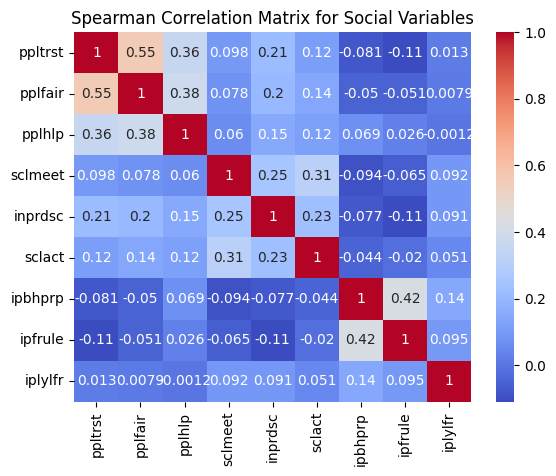

In [75]:
import seaborn as sns

# Correlation matrix
corr_matrix = social_data.corr(method='spearman')

print("Correlation Matrix:")
print(corr_matrix)

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix for Social Variables')
plt.show()

### PCA

Explained Variance Ratio: [0.24438763 0.16456875 0.14459302 0.10538187 0.08110203 0.07401745
 0.07365601 0.06265282 0.04964043]
Cumulative Explained Variance: [0.24438763 0.40895638 0.5535494  0.65893126 0.74003329 0.81405074
 0.88770675 0.95035957 1.        ]


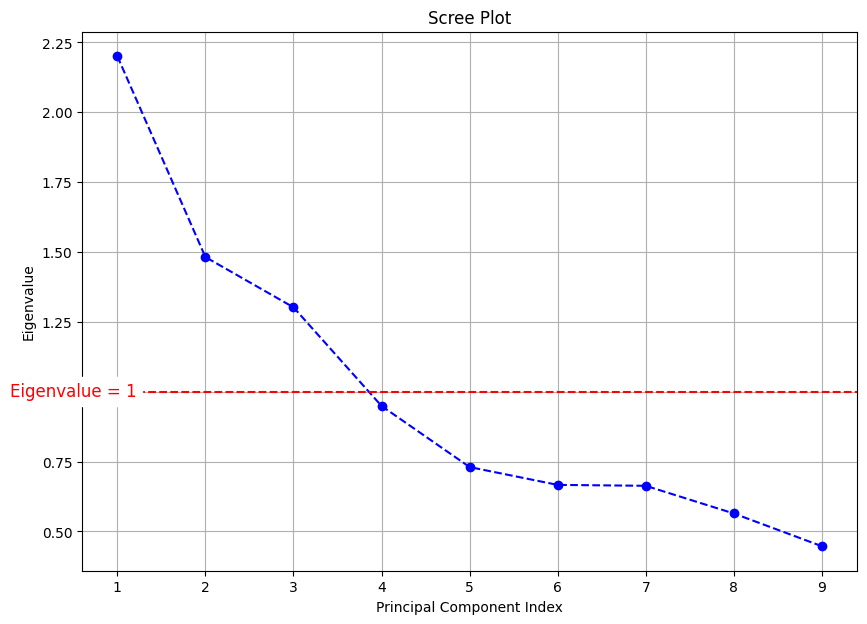

3 principal components have eigenvalues greater than 1.


In [73]:
# Standardize the data
scaler = StandardScaler()
scaled_social_data = scaler.fit_transform(social_data)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_social_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
eigenvalues = pca.explained_variance_

print("Explained Variance Ratio:", explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)

# Plot the scree plot
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--', color='b')
plt.xlabel('Principal Component Index')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid(True)
plt.axhline(y=1, color='r', linestyle='--')
plt.text(0.5, 1, 'Eigenvalue = 1', color='red', fontsize=12, va='center', ha='center', backgroundcolor='w')
plt.show()


# Alternatively, based on the Kaiser Criterion
kaiser_n_components = sum(eigenvalues > 1)
print(f"{kaiser_n_components} principal components have eigenvalues greater than 1.")

# Perform PCA with the selected number of components
pca = PCA(n_components=kaiser_n_components)
pca_result = pca.fit_transform(scaled_social_data)


In [74]:
# Get the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for the loadings
loading_df = pd.DataFrame(loadings, index=social_vars, columns=[f'PC{i+1}' for i in range(kaiser_n_components)])

print("Loadings:")
print(loading_df)

# Identify the variables with the highest absolute loadings for each principal component
highest_loadings = loading_df.apply(lambda x: x.abs().nlargest(1).index[0])

print("Variables with highest absolute loadings for each principal component:")
print(highest_loadings)


Loadings:
              PC1       PC2       PC3
ppltrst -0.718807 -0.117463  0.355629
pplfair -0.720336 -0.189580  0.364394
pplhlp  -0.566567 -0.355087  0.283729
sclmeet -0.438831  0.140786 -0.616013
inprdsc -0.571485  0.072143 -0.336297
sclact  -0.469594  0.014941 -0.513469
ipbhprp  0.207833 -0.794927 -0.099245
ipfrule  0.229435 -0.755044 -0.182702
iplylfr -0.093583 -0.280991 -0.403651
Variables with highest absolute loadings for each principal component:
PC1    pplfair
PC2    ipbhprp
PC3    sclmeet
dtype: object


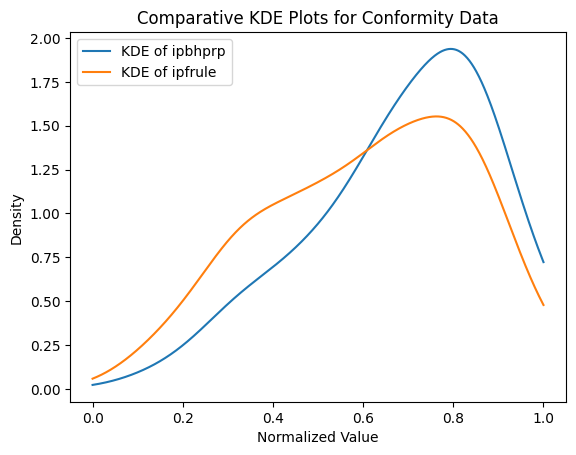

Cronbach's Alpha: 0.705398934908237


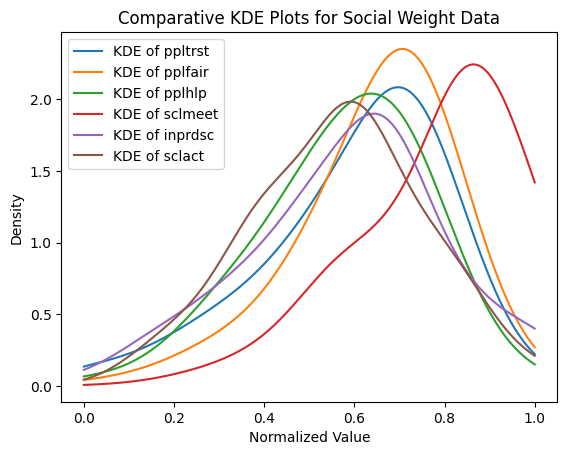

Cronbach's Alpha: 0.6406113994257987


In [61]:

# Define the variables for each attribute category
conformity_vars = ['ipbhprp', 'ipfrule']
social_weight_vars = ['ppltrst', 'pplfair', 'pplhlp', 'sclmeet', 'inprdsc', 'sclact']

# Initialize the DataFrame for conformity and social weight
conformity_data =  netherlands_df[conformity_vars].copy()
social_weight_data =  netherlands_df[social_weight_vars].copy()


conformity_vars_valid_range_dict = {
    'ipbhprp': range(1, 7),
    'ipfrule': range(1, 7),
    #'iplylfr': range(1, 7)
}


social_weight_vars_valid_range_dict = {
    'ppltrst': range(0, 11),
    'pplfair': range(0, 11),
    'pplhlp': range(0, 11),
    'sclmeet': range(1, 8),
    'inprdsc': range(0, 7),
    'sclact': range(1, 6)
}

conformity_vars_reverse_scale_dict = {
    'ipbhprp': True,   # Lower values indicate it is more like them; reverse to align.
    'ipfrule': True,   # Lower values indicate more rule-following; reverse to align.
    #'iplylfr': True    # Lower values indicate more loyalty; reverse to align.
}

social_weight_vars_reverse_scale_dict = {
    'ppltrst': False,  # Higher values indicate more trust, no need to reverse.
    'pplfair': False,  # Higher values indicate seeing people as fairer, no need to reverse.
    'pplhlp': False,   # Higher values indicate seeing people as more helpful, no need to reverse.
    'sclmeet': False,  # Higher values already indicate more frequent social meetings.
    'inprdsc': False,  # Higher values indicate more intimate connections.
    'sclact': False   # Higher values already mean more social activity
}

conformity_vars_max_value_dict = {
    'ipbhprp': 6,
    'ipfrule': 6,
    'iplylfr': 6
}

social_weight_vars_max_value_dict = {
    'ppltrst': 10,
    'pplfair': 10,
    'pplhlp': 10,
    'sclmeet': 7,
    'inprdsc': 6, 
    'sclact': 5
}

def preprocess_data(df, column, reverse, max_val):
    # Filter data
    valid_data = df[column].isin(valid_range_dict[column])
    
    # Reverse scale if necessary
    if reverse:
        df[column] = (max_val + 1) - df[column]
    
    # Normalize the data
    df[column] = df[column] / max_val
    
    return df[column][valid_data]  # Only return valid data without modifying DataFrame

# Now let's preprocess each group of variables and assign the returned series back to the DataFrame
for column in conformity_vars:
    conformity_data[column] = preprocess_data(conformity_data, column, 
                                              conformity_vars_reverse_scale_dict[column], 
                                              conformity_vars_max_value_dict[column])

for column in social_weight_vars:
    social_weight_data[column] = preprocess_data(social_weight_data, column, 
                                                 social_weight_vars_reverse_scale_dict[column], 
                                                 social_weight_vars_max_value_dict[column])


# Plotting KDE for each variable
for column in conformity_vars:
    simplified_kde_plot(column, conformity_data)

plt.title('Comparative KDE Plots for Conformity Data')
plt.xlabel('Normalized Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Calculate and print Cronbach's Alpha
alpha = cronbach_alpha(conformity_data) 
print(f"Cronbach's Alpha: {alpha}")

# Plotting KDE for each variable
for column in social_weight_vars:
    simplified_kde_plot(column, social_weight_data)

plt.title('Comparative KDE Plots for Social Weight Data')
plt.xlabel('Normalized Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Calculate and print Cronbach's Alpha
alpha = cronbach_alpha(social_weight_data) 
print(f"Cronbach's Alpha: {alpha}")


In [62]:
import pandas as pd
import numpy as np
import itertools
from sklearn.preprocessing import StandardScaler

# Define the social weight variables
social_weight_vars = ['ppltrst', 'pplfair', 'pplhlp', 'sclmeet', 'inprdsc', 'sclact']
social_weight_data = netherlands_df[social_weight_vars].copy()

valid_range_dict = {
    'ppltrst': range(0, 11),
    'pplfair': range(0, 11),
    'pplhlp': range(0, 11),
    'sclmeet': range(1, 8),
    'inprdsc': range(0, 7),
    'sclact': range(1, 6)
}

reverse_scale_dict = {
    'ppltrst': False,
    'pplfair': False,
    'pplhlp': False,
    'sclmeet': False,
    'inprdsc': False,
    'sclact': False
}

max_value_dict = {
    'ppltrst': 10,
    'pplfair': 10,
    'pplhlp': 10,
    'sclmeet': 7,
    'inprdsc': 6,
    'sclact': 5
}

# Function to preprocess data
def preprocess_data(df, column, reverse_scale, max_value):
    if reverse_scale:
        df[column] = (max_value + 1) - df[column]
    df[column] /= max_value

# Preprocess the social weight data
for column in social_weight_vars:
    social_weight_data = social_weight_data[social_weight_data[column].isin(valid_range_dict[column])]
    preprocess_data(social_weight_data, column, reverse_scale_dict[column], max_value_dict[column])

# Calculate Cronbach's Alpha
def cronbach_alpha(df):
    item_variances = df.var(axis=0, ddof=1)
    total_variance = df.sum(axis=1).var(ddof=1)
    n_items = len(df.columns)
    return (n_items / (n_items - 1)) * (1 - item_variances.sum() / total_variance)

# Find the best combination of variables
best_alpha = 0
best_combination = []

for size in [2, 6]:
    for combination in itertools.combinations(social_weight_vars, size):
        subset = social_weight_data[list(combination)].dropna()
        alpha = cronbach_alpha(subset)
        if alpha > best_alpha:
            best_alpha = alpha
            best_combination = combination

print(f"Best combination of variables: {best_combination}")
print(f"Cronbach's Alpha for the best combination: {best_alpha}")


Best combination of variables: ('ppltrst', 'pplfair')
Cronbach's Alpha for the best combination: 0.6962762962841347


## Job stability



hincfel - feeling about household's income nowadays

lkuemp - how likely unemployed and looking for work next 12 month 

lknemny - how likely not enough money for household necessities next 12 months

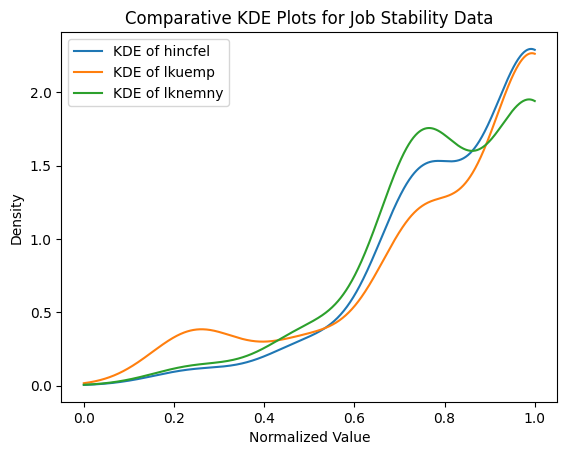

Cronbach's Alpha: 0.6910552619651942


In [79]:
job_stability_vars = [ 'hincfel', 'lkuemp', 'lknemny']
job_stability_data = netherlands_df[job_stability_vars].copy()

# Valid range dictionary based on your understanding of the variables
valid_range_dict = {
    #'icpdwrk': range(1, 3),  # Adjusted to include actual ranges
    #'wrkctra': range(1, 4),
    'hincfel': range(1, 5),
    'lkuemp': range(1, 5),
    'lknemny': range(1, 5)
}

reverse_scale_dict = {
    #'icpdwrk': True,  # 1 for in paid work is positive, no reversal; 2 for not in paid work needs reversal
    #'wrkctra': False, # Unlimited contract (1) is more stable, limited (2) or no contract (3) are less stable
    'hincfel': True,   # Higher numbers indicate more difficulty living on income, so reverse to align with stability
    'lkuemp': True,
    'lknemny': True
}

max_value_dict = {
    #'icpdwrk': 2,  # 1 in work, 2 not in work, thus max is 2
    #'wrkctra': 3,  # Unlimited, limited, no contract
    'hincfel': 4,   # From living comfortably to very difficult
    'lkuemp': 4,
    'lknemny': 4
}

# Preprocessing data
for column in job_stability_vars:
    original_count = job_stability_data.shape[0]
    job_stability_data = job_stability_data[job_stability_data[column].isin(valid_range_dict[column])]
    filtered_count = job_stability_data.shape[0]
    #print(f"{column}: Reduced from {original_count} to {filtered_count}")
    preprocess_data(job_stability_data, column, reverse_scale_dict[column], max_value_dict[column])


# Plotting KDE for each variable
for column in job_stability_vars:
    simplified_kde_plot(column, job_stability_data)

plt.title('Comparative KDE Plots for Job Stability Data')
plt.xlabel('Normalized Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Calculate and print Cronbach's Alpha
alpha = cronbach_alpha(job_stability_data)  # Ensure no NaNs before calculating
print(f"Cronbach's Alpha: {alpha}")

Explained Variance Ratio: [0.63366076 0.23796225 0.12837698]
Cumulative Explained Variance: [0.63366076 0.87162302 1.        ]


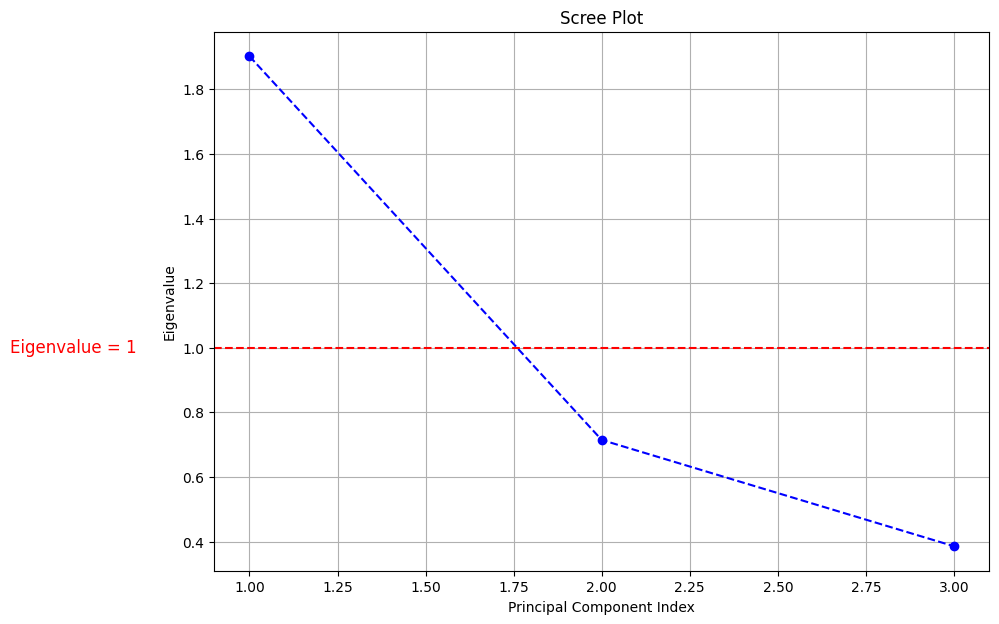

1 principal components have eigenvalues greater than 1.


In [81]:
# Standardize the data
scaler = StandardScaler()
scaled_job_stability_data = scaler.fit_transform(job_stability_data)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_job_stability_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
eigenvalues = pca.explained_variance_

print("Explained Variance Ratio:", explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)

# Plot the scree plot
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--', color='b')
plt.xlabel('Principal Component Index')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.grid(True)
plt.axhline(y=1, color='r', linestyle='--')
plt.text(0.5, 1, 'Eigenvalue = 1', color='red', fontsize=12, va='center', ha='center', backgroundcolor='w')
plt.show()

# Alternatively, based on the Kaiser Criterion
kaiser_n_components = sum(eigenvalues > 1)
print(f"{kaiser_n_components} principal components have eigenvalues greater than 1.")

# Perform PCA with the selected number of components
pca = PCA(n_components=kaiser_n_components)
pca_result = pca.fit_transform(scaled_job_stability_data)


In [82]:
# Get the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for the loadings
loading_df = pd.DataFrame(loadings, index=job_stability_vars, columns=[f'PC{i+1}' for i in range(kaiser_n_components)])

print("Loadings:")
print(loading_df)
# Identify the variables with the highest absolute loadings for each principal component
highest_loadings = loading_df.apply(lambda x: x.abs().nlargest(1).index[0])

print("Variables with highest absolute loadings for each principal component:")
print(highest_loadings)


Loadings:
              PC1
hincfel -0.795997
lkuemp  -0.709803
lknemny -0.874620
Variables with highest absolute loadings for each principal component:
PC1    lknemny
dtype: object


          hincfel    lkuemp   lknemny
hincfel  1.000000  0.236853  0.478543
lkuemp   0.236853  1.000000  0.492298
lknemny  0.478543  0.492298  1.000000


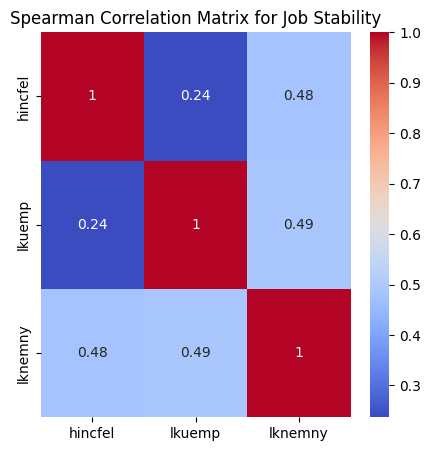

In [77]:
# Correlation matrix
plt.figure(figsize=(5, 5))
corr_matrix = job_stability_data.corr(method='spearman')
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix for Job Stability')
plt.show()

Explained variance ratio: [0.63366076 0.23796225]
Total explained variance by the first component: 0.6336607646111289


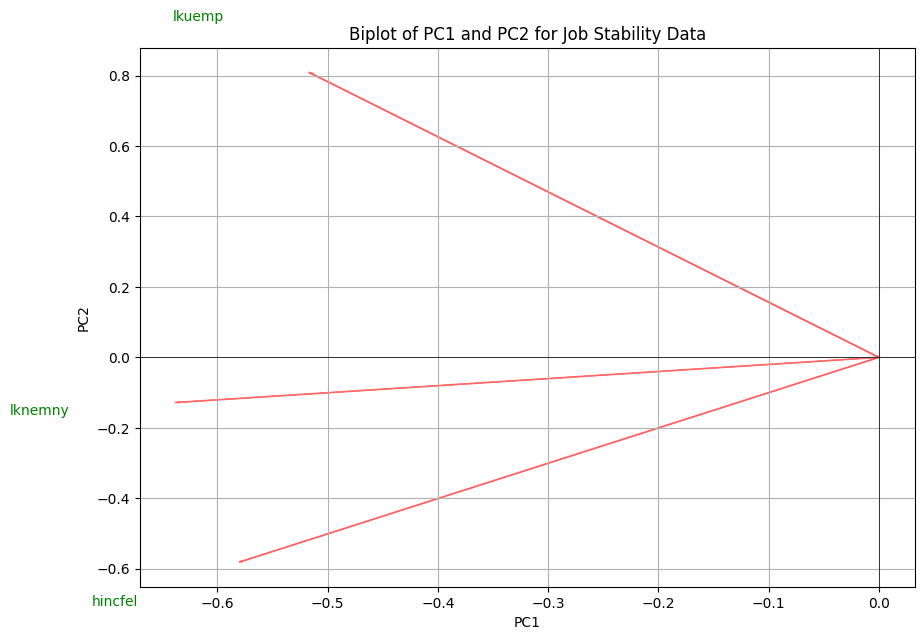

In [107]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(job_stability_data)  

# Applying PCA
pca = PCA(n_components=2)  # Adjust based on the variance you need to capture
principal_components = pca.fit_transform(scaled_data)
# Create a DataFrame to display principal components more clearly
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(2)])

# Loadings of the variables on each principal component
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(2)], index=job_stability_data.columns)
loadings

explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("Total explained variance by the first component:", explained_variance[0])

# Creating a biplot
plt.figure(figsize=(10, 7))
origin = [0, 0]  # origin point

# Plot loadings
for i, (comp1, comp2) in enumerate(loadings.values):
    plt.arrow(origin[0], origin[1], comp1, comp2, color='r', alpha=0.5)
    plt.text(comp1*1.2, comp2*1.2, job_stability_data.columns[i], color='g', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of PC1 and PC2 for Job Stability Data')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

## Weight Financial

'imprich' - Important to be rich, have money and expensive things


# Final attributes for agents

In [87]:


# Load your data
df = pd.read_csv('/Applications/UNI/Thesis/datasets/ESS8e02_3.csv')

# Filter the DataFrame for rows where 'cntry' is 'NL'
netherlands_df = df[df['cntry'] == 'NL']

# Define the selected variables and their properties
selected_vars = {
    'impenv': {'valid_range': range(1, 7), 'reverse_scale': True, 'max_value': 6},
    'ccrdprs': {'valid_range': range(0, 11), 'reverse_scale': False, 'max_value': 10},
    'ipfrule': {'valid_range': range(1, 7), 'reverse_scale': True, 'max_value': 6},
    'ppltrst': {'valid_range': range(0, 11), 'reverse_scale': False, 'max_value': 10},
    'imprich': {'valid_range': range(1, 7), 'reverse_scale': True, 'max_value': 6},
    'lknemny': {'valid_range': range(1, 5), 'reverse_scale': True, 'max_value': 4}
}

# Function to process each variable
def process_variable(df, column, valid_range, reverse_scale=False, max_value=None):
    valid_df = df[df[column].isin(valid_range)].copy()
    valid_df[column] = valid_df[column].astype(float)
    if reverse_scale:
        valid_df[column] = (max_value + 1) - valid_df[column]
    valid_df[column] = valid_df[column] / max_value
    valid_df[column] = np.clip(valid_df[column], 0, 1)
    return valid_df[[column]]

# Process and combine the variables
processed_vars = []
for var, props in selected_vars.items():
    processed_var = process_variable(netherlands_df, var, props['valid_range'], props['reverse_scale'], props['max_value'])
    processed_vars.append(processed_var)

# Combine all processed variables into a single DataFrame
processed_df = pd.concat(processed_vars, axis=1)

# Check for NaN values in the processed DataFrame
print("Checking for NaN values in the processed data:")
na_counts = processed_df.isna().sum()
total_count = len(processed_df)
for var in processed_df.columns:
    print(f"{var}: {na_counts[var]} NaN values out of {total_count} total values")

# Drop rows with NaN values
processed_df.dropna(inplace=True)

# Display the first few rows of the processed DataFrame
print(processed_df)

# Save the processed DataFrame to a new CSV file
processed_df.to_csv('/Applications/UNI/Thesis/datasets/processed_dutch_population.csv', index=False)


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_2989/3960229025.py:2: DtypeWarning: Columns (168) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Applications/UNI/Thesis/datasets/ESS8e02_3.csv')


Checking for NaN values in the processed data:
impenv: 11 NaN values out of 1681 total values
ccrdprs: 29 NaN values out of 1681 total values
ipfrule: 26 NaN values out of 1681 total values
ppltrst: 1 NaN values out of 1681 total values
imprich: 10 NaN values out of 1681 total values
lknemny: 18 NaN values out of 1681 total values
         impenv  ccrdprs   ipfrule  ppltrst   imprich  lknemny
32909  0.833333      0.8  0.333333      0.9  0.500000     1.00
32910  0.833333      0.5  0.666667      0.7  0.333333     0.75
32911  0.833333      0.7  0.500000      0.6  0.500000     0.75
32912  0.666667      0.5  0.500000      0.7  0.666667     1.00
32913  0.833333      0.7  1.000000      0.6  0.333333     0.50
...         ...      ...       ...      ...       ...      ...
34584  1.000000      0.8  0.666667      0.7  0.333333     0.75
34585  0.833333      0.5  0.666667      0.5  0.166667     0.75
34586  0.833333      0.7  0.833333      0.8  0.666667     0.75
34587  0.500000      0.2  0.666667   

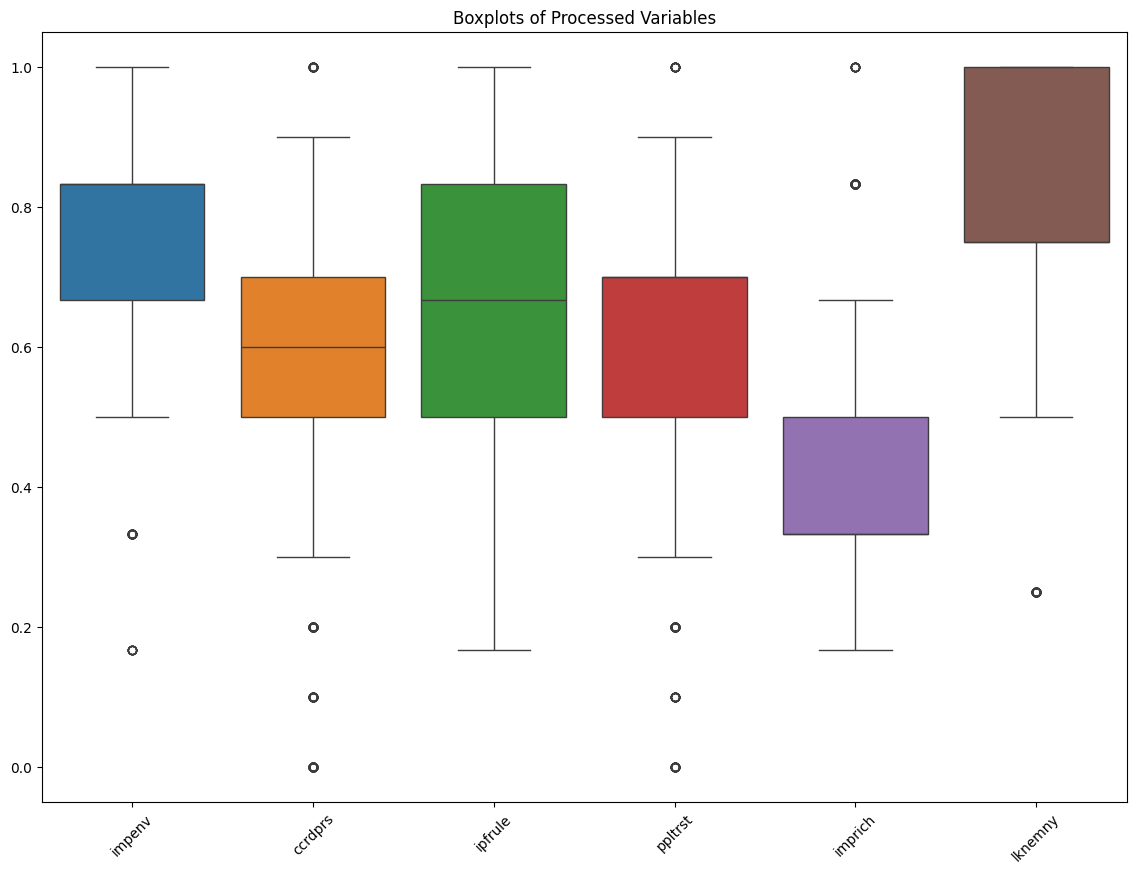

In [90]:


# Boxplots
plt.figure(figsize=(14, 10))
sns.boxplot(data=processed_df)
plt.title('Boxplots of Processed Variables')
plt.xticks(rotation=45)
plt.show()



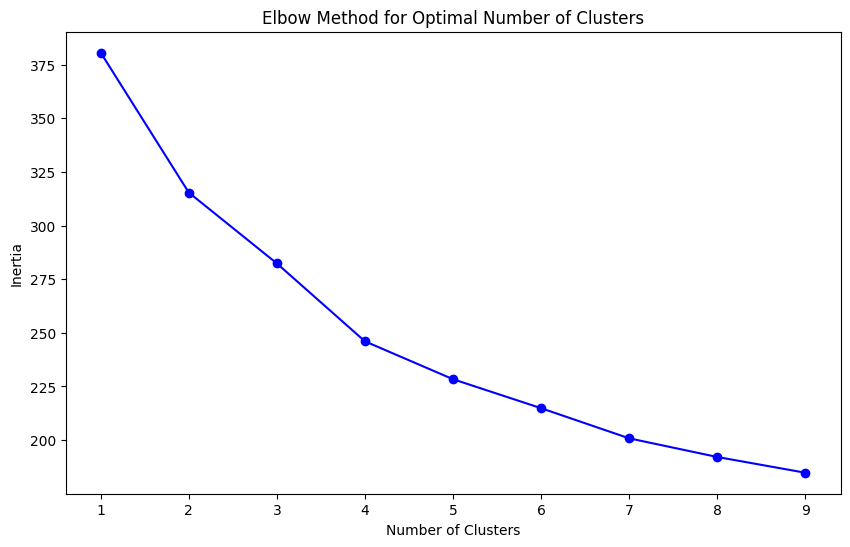

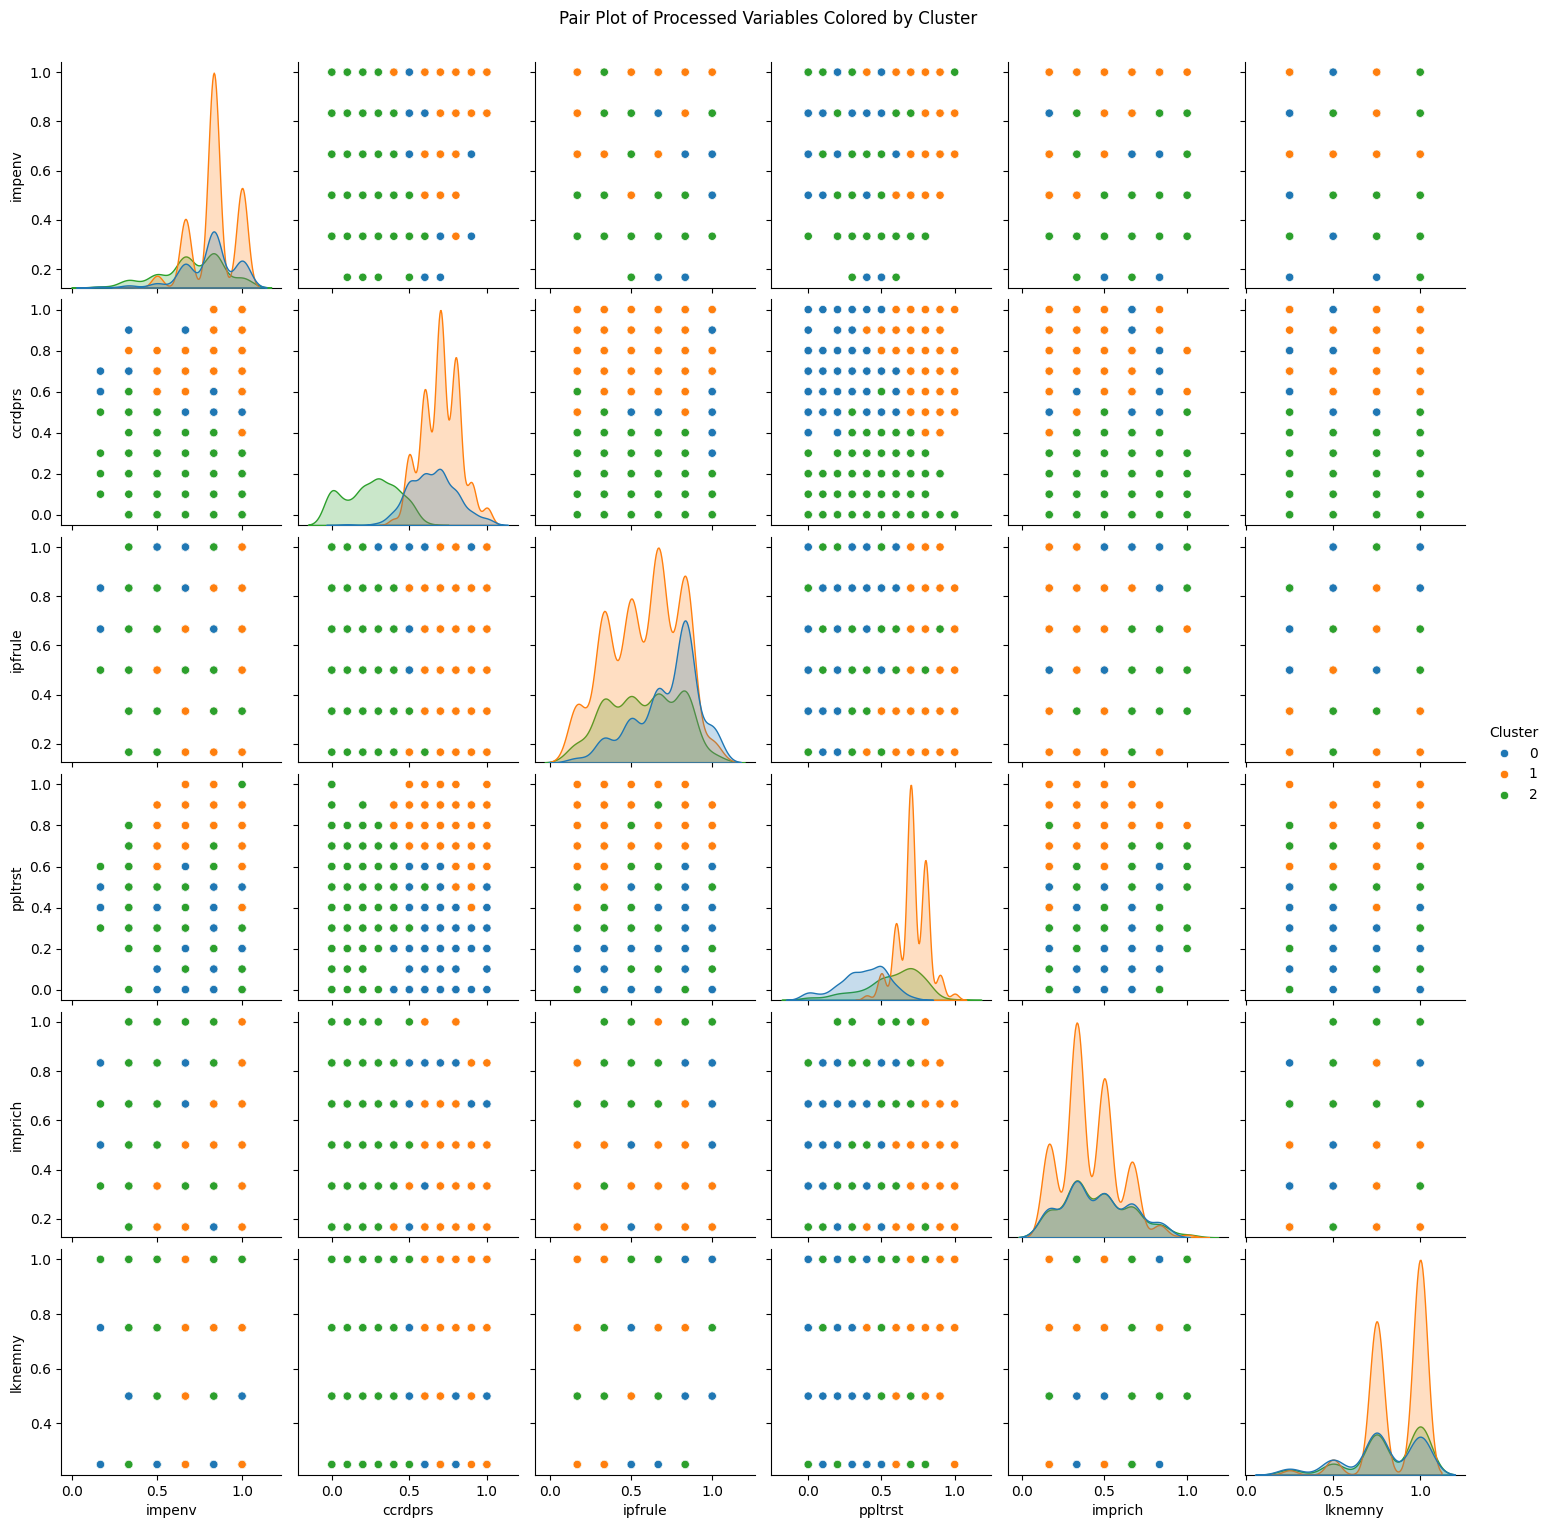

In [92]:
from sklearn.cluster import KMeans

# Determine the number of clusters using the elbow method
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_df)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Perform K-Means clustering with the optimal number of clusters
optimal_k = 3  # Replace with the optimal number of clusters determined from the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(processed_df)

# Add cluster labels to the DataFrame
processed_df['Cluster'] = clusters

# Visualize clusters in a pair plot
sns.pairplot(processed_df, hue='Cluster', palette='tab10')
plt.suptitle('Pair Plot of Processed Variables Colored by Cluster', y=1.02)
plt.show()


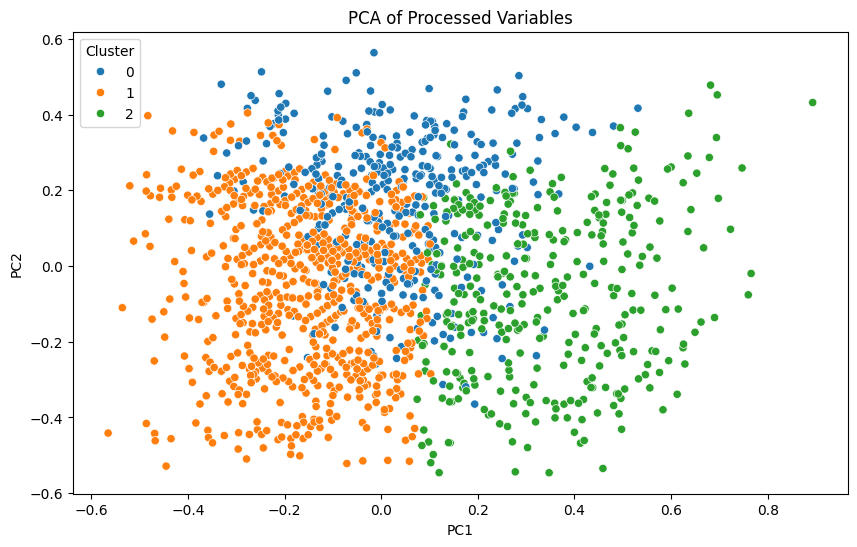

In [93]:
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(processed_df.drop('Cluster', axis=1))

# Add PCA results to the DataFrame
processed_df['PC1'] = pca_result[:, 0]
processed_df['PC2'] = pca_result[:, 1]

# Scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='tab10', data=processed_df, legend='full')
plt.title('PCA of Processed Variables')
plt.show()
